### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population by county](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa population by city](https://data.iowa.gov/Community-Demographics/Iowa-Population-by-City-ACS-5-Year-Estimates-/26ad-icvy/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)
- [iowa fuel sales](https://data.iowa.gov/Sales-Distribution/Iowa-Motor-Fuel-Sales-by-County-and-Year/hbwp-wys3/about_data)
- [iowa excessive drinking](https://www.countyhealthrankings.org/health-data/community-conditions/health-infrastructure/health-promotion-and-harm-reduction/excessive-drinking?state=19&tab=1&year=2025)

### Packages

In [2]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata
import re

# 1. Load Data

In [ ]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    store_location,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date>='2024-01-01' AND date<'2025-01-01' AND state_bottle_cost>0 AND state_bottle_retail>0
AND bottles_sold>0 AND sale_dollars>0
"""

df_google_cloud = pandas_gbq.read_gbq(sql, credentials=credentials)
df_google_cloud.to_csv('liquor.csv', index=False)

Downloading: 100%|██████████|


In [3]:
df_google = pd.read_csv('data/liquor.csv')
df_google['longitude'] = df_google['store_location'].str.extract(r'POINT\(([-\d\.]+) [-\d\.]+\)').astype(float)
df_google['latitude'] = df_google['store_location'].str.extract(r'POINT\([-\d\.]+ ([-\d\.]+)\)').astype(float)
df_google['gross_profit'] = (
    (df_google['state_bottle_retail'] - df_google['state_bottle_cost']) * df_google['bottles_sold']
)
df_google.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
    'bottles_sold': 'bottles',
}, inplace=True)
df_google.columns = df_google.columns.str.lower()
df_google['store'] = df_google['store'].str.lower()
df_google['city'] = df_google['city'].str.lower()
df_google['county'] = df_google['county'].str.lower()
df_google['item'] = df_google['item'].str.lower()
df_google = df_google[['date', 'store', 'city', 'county', 'longitude', 'latitude', 'item', 'state_bottle_cost', 'state_bottle_retail', 'bottles', 'sale_dollars', 'gross_profit']]
df_google                    

,date,store,city,county,longitude,latitude,item,state_bottle_cost,state_bottle_retail,bottles,sale_dollars,gross_profit
0,2024-11-07,super quick liquor / wdm,west des moines,polk,-93.736600,41.599070,rumchata coconut mini,8.87,13.31,1,13.31,4.44
1,2024-07-16,casey's general store # 3604/hinton,hinton,plymouth,-96.292271,42.627687,frost trail vodka mini,3.93,5.90,1,5.90,1.97
2,2024-10-09,hy-vee food store #1 (1013) / ames,ames,story,-93.563320,42.022970,killr variety pack mini,27.28,40.92,1,40.92,13.64
3,2024-09-06,snak atak #53 / keystone,keystone,benton,-92.198670,42.003580,crown royal vanilla mini,5.76,8.64,1,8.64,2.88
4,2024-01-24,hy-vee #5 / davenport,davenport,scott,-90.612323,41.536627,crown royal regal apple mini,9.95,14.93,1,14.93,4.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2587987,2024-11-17,super quick 2 / hubbell,des moines,polk,-93.586520,41.596040,99 watermelon pet mini,52.40,78.60,1,78.60,26.20
2587988,2024-11-14,casey's general store #3098 / wdm,west des moines,polk,-93.703760,41.582710,fireball cinnamon whiskey party bucket,52.40,78.60,2,157.20,52.40
2587989,2024-12-10,hy-vee drugstore #5 / cedar rapids,cedar rapids,linn,-91.669130,42.034800,fireball cinnamon whiskey party bucket,52.40,78.60,2,157.20,52.40
2587990,2024-09-13,casey's general store #3294 / urbana,urbana,benton,-91.889529,42.246579,fireball cinnamon whiskey adult trick or treat...,52.40,78.60,2,157.20,52.40


In [9]:
print("The earliest date:", df_google['date'].min())
print("The latest date:", df_google['date'].max())
print("# of stores:", df_google['store'].nunique())
print("# of cities:", df_google['city'].nunique())
print("# of counties:", df_google['county'].nunique())
print("# of items:", df_google['item'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2150
# of cities: 471
# of counties: 99
# of items: 4515


## 1-1. Liquor Stores

In [4]:
df_store = (
    df_google
    .groupby(['store', 'city', 'county', 'longitude', 'latitude', 'date', 'item'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store

,store,city,county,longitude,latitude,date,item,bottles,gross_profit
0,'da booze barn / west bend,west bend,palo alto,-94.445160,42.959230,2024-10-02,ballotin chocolate whiskey caramel turtle mini,1,5.00
1,'da booze barn / west bend,west bend,palo alto,-94.445160,42.959230,2024-10-02,ballotin chocolate whiskey mini,1,5.00
2,'da booze barn / west bend,west bend,palo alto,-94.445160,42.959230,2024-10-02,ballotin peanut butter chocolate whiskey mini,1,5.00
3,'da booze barn / west bend,west bend,palo alto,-94.445160,42.959230,2024-10-02,bookers bourbon,1,25.00
4,'da booze barn / west bend,west bend,palo alto,-94.445160,42.959230,2024-10-02,crown royal regal apple,6,102.00
...,...,...,...,...,...,...,...,...,...
2344885,yesway store #1198 / swea city,swea city,kossuth,-94.307848,43.385321,2024-07-31,crown royal regal apple mini,10,29.60
2344886,yesway store #1198 / swea city,swea city,kossuth,-94.307848,43.385321,2024-07-31,fireball cinnamon whiskey,72,124.08
2344887,yesway store #1198 / swea city,swea city,kossuth,-94.307848,43.385321,2024-07-31,fireball cinnamon whiskey pet,18,102.00
2344888,yesway store #1198 / swea city,swea city,kossuth,-94.307848,43.385321,2024-07-31,hawkeye vodka,42,72.66


In [11]:
print('Summary of bottles:\n', df_store['bottles'].describe())
print()
print('Summary of gross profit:\n', df_store['gross_profit'].describe())

Summary of bottles:
 count    2.346524e+06
mean     1.338831e+01
std      3.826499e+01
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.200000e+01
max      1.323000e+04
Name: bottles, dtype: float64

Summary of gross profit:
 count    2.346524e+06
mean     6.360567e+01
std      2.255607e+02
min      4.800000e-01
25%      1.800000e+01
50%      3.300000e+01
75%      6.216000e+01
max      8.727300e+04
Name: gross_profit, dtype: float64


## 1-2. Population

In [5]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city = df_pop_city[['city', 'pop_city']]
df_pop_city

,city,pop_city
0,ackley,1699
1,ackworth,106
2,adair,828
3,adel,6090
4,afton,1105
...,...,...
936,yale,316
937,yetter,16
938,yorktown,35
939,zearing,655


In [6]:
df_pop_county = pd.read_csv('data/population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['fips','county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']

df_geo_county = pd.read_csv('data/geo_county.csv')
df_geo_county.rename(columns={
    'Geographic Area Name (NAME)': 'county',
    'Internal Point (Latitude) (INTPTLAT)': 'latitude',
    'Internal Point (Longitude) (INTPTLON)': 'longitude'
}, inplace=True)
df_geo_county.columns = df_geo_county.columns.str.lower()
df_geo_county['county'] = df_geo_county['county'].str[:-13]
df_geo_county['county'] = df_geo_county['county'].str.lower()
df_geo_county = df_geo_county[['county','latitude', 'longitude']]

df_pop_geo_county = pd.merge(df_pop_county, df_geo_county, on='county', how='left')
df_pop_geo_county.to_csv('data/pop_geo_county.csv', index=False)
df_pop_geo_county

,fips,county,year,pop_county,latitude,longitude
0,19157,poweshiek,2023,18453,41.684642,−92.5229344
1,19101,jefferson,2023,15440,41.006376,−91.9666277
2,19037,chickasaw,2023,11658,43.059741,−92.3172101
3,19131,mitchell,2023,10518,43.348564,−92.7844663
4,19197,wright,2023,12656,42.733007,−93.7347352
...,...,...,...,...,...,...
94,19187,webster,2023,36485,42.433579,−94.1758309
95,19149,plymouth,2023,25722,42.737585,−96.2158638
96,19065,fayette,2023,19210,42.864122,−91.8403761
97,19099,jasper,2023,37919,41.685551,−93.0541468


## 1-3. Income

In [7]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105
...,...,...,...
4939,winnebago,2022,55013
4991,winneshiek,2022,61042
5043,woodbury,2022,51029
5095,worth,2022,55418


## 1-4. Fuel Sales

In [8]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("hbwp-wys3",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_fuel = pd.DataFrame.from_records(df_list)
df_fuel.rename(columns={
    'calendar_year': 'year',
    # 'number_of_retail_locations': 'locations',
    'non_ethanol_gas_sales': 'gas_sales',
}, inplace=True)
df_fuel = df_fuel[df_fuel['year']=='2024']
df_fuel['county'] = df_fuel['county'].str.lower()
df_fuel = df_fuel[['county', 'gas_sales']]
df_fuel

,county,gas_sales
1174,adair,895851
1175,adams,188155
1176,allamakee,923224
1177,appanoose,792131
1178,audubon,226034
...,...,...
1268,winnebago,582020
1269,winneshiek,976372
1270,woodbury,7032420
1271,worth,445045


## 1-5. Excessive Drinking

In [9]:
df_drinking = pd.read_csv('data/excessive_drinking.csv')
df_drinking.columns = df_drinking.columns.str.lower()
df_drinking.rename(columns={
    'county value**': 'excessive_drinking_percent',
}, inplace=True)
df_drinking['county'] = df_drinking['county'].str.lower()
df_drinking['excessive_drinking_percent'] = df_drinking['excessive_drinking_percent'].str[:2]
df_drinking = df_drinking[['county', 'excessive_drinking_percent']]
df_drinking

,county,excessive_drinking_percent
0,iowa,25
1,adair,24
2,adams,25
3,allamakee,23
4,appanoose,23
...,...,...
95,winnebago,24
96,winneshiek,27
97,woodbury,25
98,worth,25


## 1-6. Age Population

# 2. Data Frame

## 2-1. Basic Data Frame

In [17]:
# merge
df_county = pd.merge(df_pop_county, df_income, on='county', how='left')
df_county = pd.merge(df_county, df_fuel, on='county', how='left')
df_county = pd.merge(df_county, df_drinking, on='county', how='left')
df_county = df_county[['county', 'pop_county', 'annual_income', 'gas_sales', 'excessive_drinking_percent']]
df = pd.merge(df_store, df_pop_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['pop_city'] = df['pop_city'].astype('Int64')
df['gas_sales'] = df['gas_sales'].astype(int)
df['excessive_drinking_percent'] = df['excessive_drinking_percent'].astype(int)

# categorize stores
def assign_category(store_name):
    # Ensure store_name is a string; if not, use an empty string.
    store = store_name.lower() if isinstance(store_name, str) else ""
    
    # Remove punctuation from the store name to avoid matching issues with characters like '/'
    store_clean = store
    
    # General stores and convenience stores may be combined later
    # Brew oil is a chain of liquor stores at gas stations. Included under gas station for now
    # The difference between convenience store and gas station, is the latter also sells gas
    # Some meat only stores are placed into grocery stores (fire and salt co, forbes meat)
    categories = {
        "grocery store": ["groc", "super saver iv", "sunshine foods", "sioux food center", "shivam food mart llc", "save more", "food pride", "sam's food", "sam food mart", "roy's foodland", "quillins quality foods", "quillins food ranch", "osco #1118", "state food mart", "strawberry food", "stratford food center", "super saver iv," "sam food mart", "ruback's food center", "terry's food center", "sam's club", "target", "price chopper", "quillins quality foods west union", "r&l foods", "mepo foods", "montezuma super valu", "mcnally's super valu", "maynards", "mapleton food land", "logan super foods", "laurens food pride", "lake city food center", "lansing iga", "lake view foods",  "la tropicana", "kyaw family, inc", "jim and charlies affiliated", "keota eagle foods", "jubilee foods", "jeff's foods", "jeffs foods", "jack & jill store", "ida grove food pride", "gary's foods", "grandview mart", "hy-vee", "hometown foods", "the food center", "frohlich's super valu", "fredricksburg food center", "freeman foods", "fire and salt co", "forbes meat", "feista foods", "family fare",  "fairbank food center", "el valle tienda y carniceria", "davids foods", "thriftway", "country foods", "tipton family foods", "center point foods", "dashmart", "corwith farm service", "clear lake payless foods", "britt food center", "fareway stores", "dutchmart", "eagle food mart", "bob & scott's", "cash saver", "best food mart", "byron mart", "big g food store", "bender's foods", "bender foods", "trunck's country foods, inc", "avoca food land", "avenue g store", "audubon food land", "costco", "whole foods", "trader joe", "wmart", "fresh", "wilkes", "wikes", "market", "wal-mart"],
        "liquor store/bar": ["8 seconds", "riverside #4 / bettendorf", "sun mart", "subedi llc", "ss khanna group inc", "south side food mart", "smokin hot", "sip & burn", "sid's beverage shop", "royal mart", "puff pour play inc", "jumbo's", "super quick", "the hut", "prime mart", "swarm sports bar and grille", "oasis", "the cooler", "the beverage shop", "new star", "new hampton mart", "metro mart", "malik's",  "local craft cellar", "last call 2", "kimberly mart", "hurribak iv distribution", "great pastimes", "grieder beverage depot", "the secret cellar", "essentials plus", "essentials",  "eldridge mart", "easygo", "downtown pantry", "division mart", "ding's honk'n holler", "concordia llc", "chuck's sportsmans beverage", "bani's", "cork 'n bottle", "cork and bottle", "cork it!", "brady mart", "benz distributing", "brewski", "blind pig cocktail bodega", "bootleg", "brew ida grove", "camanche food pride", "beer", "another round", "ambysure inc", "whiskey", "shack", "liquor", "booze", "spirits", "wine", "smoke", "tobacco", "ali's"],
        "gas station": ["yana mart", "super convenience store", "speede shop", "southgate ames", "snak atak #53", "site food mart", "sioux-per center", "sinclair", "select mart", "rolfe heartland", "river mart", "rina mart llc", "quik and handi", "quick shop foods", "quick mart", "quick corner", "pump n pack", "primestar", "porters convenience 66", "pony express", "oak street station llc", "speedee mart", "stan's corner", "star / denison", "star convenience", "super mart", "quik n handi iii", "truck plaza inc.", "shop n save", "pump 'n pak", "raymond's station", "taylor's", "phillips 66", "the spot #3", "otho convenience and food", "oskaloosa watering hole", "oly's c store", "oelwein mart", "panther travel center", "quik pik", "raceway 80", "quik trip", "the pumper", "the corner store", "the boonedocks", "naaz group llc", "moes mart", "mod /", "mk minimart, inc", "mini-mart", "mega saver", "mega retail", "mcdermott oil", "mason mart", "martelle store", "locust mart", "lefty's convenience", "l&m mighty shop", "kramer's inc.", "jiffy", "the depot", "kwik star", "kwik shop", "konvenience korner", "kline's quick time", "kimmes", "kj's convenience & deli", "karam kaur khasriya llc", "jj's valley mart", "country store", "indy 66", "gd xpress", "garner foods", "fastland llc", "crossroads / hampton", "the depot williamsburg", "hill country convenience store", "hill brothers jiffy mart", "hello mart llc", "golden mart", "good and quick co", "hawkeye convenience store", "filling station", "the station", "speed shoppe", "speede shoppe", "fast break", "ampride", "fas mart", "engen express", "ehlinger's vinton express", "dhakals llc", "dewitt travel mart", "depot norway", "decorah mart", "day break", "cresco mart", "corydon corner", "circle s", "budzz", "ez mart", "e z mart", "express mart", "cubby's", "corner mart", "bucky's", "central mart i, llc", "conoco", "car-go-express", "circle k", "best trip", "thunder ridge", "the station ii", "calamus country store", "brew floyd", "tiger mart", "casey's", "brew oil", "shell", "bailey's convenience", "b and b west", "b p on 1st", "uni mart", "andrew country mart", "westland fast", "westside houser mart", "junction", "gas", "sheetz", "four corners", "petro", "wawa", "bp", "quiktrip", "buc-ee", "380bp", "fuel", "kum", "stop", "yesway", "wilton express", "williams travel"],
        "pharmacy": ["pharmacy", "cvs", "walgreen", "cornerstone apothecary", "hartig drug"],
        "distillery/brewery": ["distill", "legendary rye", "brewery", "vineyard", "catfish charlie's"],
        "general store": ["general", "bellevue express", "guppy's on the go", "huber's store", "gateway mart" ],
        "convenience store": ["7/11", "sahota food mart", "station mart", "sycamore convenience", "mughal, inc", "neighborhood mart", "moti's food", "mad ave quik shop", "kc brothers", "jim's food", "east village pantry", "family pantry", "gm minimart", "gm mart", "gm food mart",  "bravim mart incorporated", "carson country store llc", "big 10 mart", "umiya foodmart inc", "7 days mart", "valley west corner store", "mini mart", "west k mart"],
        "other": ["williams boulevard service", "sodes green acre", "prairie meadows", "gopuff", "ib pony", "new york dollar store", "franklin street floral & gift", "eichman enterprises inc", "inn & suites", "budget inn", "10th", "adventureland", "whiting", "casino", "w&h cooperative oil co", "troy mills / troy mills" ],
        "unknown" : ["best deals / waterloo", "central city 2", "k-zar inc - waterloo", "kc store / stratford", "larchwood offsale", "rienbeck gp llc / reinbeck"] 
    }
    
    # Loop over the categories in the order given.
    for category, keywords in categories.items():
        # If any keyword is found in the cleaned store name, return the category.
        if any(keyword in store_clean for keyword in keywords):
            return category
    return "uncategorized"

df['category'] = df['store'].apply(assign_category)

# date to month
df['month'] = pd.to_datetime(df['date']).dt.month

# save to csv
df.to_csv('data/iowa.csv', index=False)

df.head()

,store,city,county,longitude,latitude,date,item,bottles,gross_profit,pop_city,pop_county,annual_income,gas_sales,excessive_drinking_percent,category,month
0,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin chocolate whiskey caramel turtle mini,1,5.0,936,8810,65080,306384,26,liquor store/bar,10
1,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin chocolate whiskey mini,1,5.0,936,8810,65080,306384,26,liquor store/bar,10
2,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,ballotin peanut butter chocolate whiskey mini,1,5.0,936,8810,65080,306384,26,liquor store/bar,10
3,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,bookers bourbon,1,25.0,936,8810,65080,306384,26,liquor store/bar,10
4,'da booze barn / west bend,west bend,palo alto,-94.44516,42.95923,2024-10-02,crown royal regal apple,6,102.0,936,8810,65080,306384,26,liquor store/bar,10


## 2-2. Item Data Frame

In [17]:
df = pd.read_csv('data/iowa.csv')
df_items = df.pivot_table(
    index=['store', 'month'],   
    columns='item',            
    values='bottles',          
    aggfunc='sum',              
    fill_value=0            
)
df_items = df_items.reset_index()
df_items

item,store,month,10th mountain american single malt,10th mountain bourbon,10th mountain brandy,10th mountain cordial,10th mountain rye,10th mountain vodka,135 east hyogo japanese gin,15 stars private stock 8 and 15yr,...,yu,yukon jack,yukon jack fire,yukon jack perma frost,zaya gran reserva rum,zing zang blazing bloody mary rts,zing zang bloody mary rts,zirbenz stone pine liqueur of the alps,zubrowka bison grass vodka,zucca rabarbaro
0,'da booze barn / west bend,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,'da booze barn / west bend,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,'da booze barn / west bend,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,'da booze barn / west bend,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,'da booze barn / west bend,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23049,yesway store #1198 / swea city,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23050,yesway store #1198 / swea city,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23051,yesway store #1198 / swea city,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23052,yesway store #1198 / swea city,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2-3. Gross Profit Data Frame

In [18]:
df_profit = (
    df.groupby(
        ['store',
         'category',
         'month', 
         'longitude', 
         'latitude', 
         'city', 
         'county',
         'pop_city',
         'annual_income',
         'gas_sales',
         'excessive_drinking_percent']
         )['gross_profit']
         .sum()
         .reset_index(name='gross_profit')
)

# change category to dummies
df_profit = pd.get_dummies(df_profit, columns=['category'], prefix='cat')
bool_cols = df_profit.select_dtypes(include='bool').columns
df_profit[bool_cols] = df_profit[bool_cols].astype(int)

df_profit


,store,month,longitude,latitude,city,county,pop_city,annual_income,gas_sales,excessive_drinking_percent,gross_profit,cat_convenience store,cat_distillery/brewery,cat_gas station,cat_general store,cat_grocery store,cat_liquor store/bar,cat_other,cat_pharmacy,cat_unknown
0,'da booze barn / west bend,1,-94.444878,42.959231,west bend,palo alto,936.0,65080,306384,26,4499.84,0,0,0,0,0,1,0,0,0
1,'da booze barn / west bend,2,-94.444878,42.959231,west bend,palo alto,936.0,65080,306384,26,4598.18,0,0,0,0,0,1,0,0,0
2,'da booze barn / west bend,3,-94.444878,42.959231,west bend,palo alto,936.0,65080,306384,26,4840.74,0,0,0,0,0,1,0,0,0
3,'da booze barn / west bend,4,-94.444878,42.959231,west bend,palo alto,936.0,65080,306384,26,3828.55,0,0,0,0,0,1,0,0,0
4,'da booze barn / west bend,5,-94.444878,42.959231,west bend,palo alto,936.0,65080,306384,26,4691.36,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22961,yesway store #1198 / swea city,7,-94.307848,43.385321,swea city,kossuth,690.0,66517,529531,24,1773.04,0,0,1,0,0,0,0,0,0
22962,yesway store #1198 / swea city,9,-94.307890,43.384960,swea city,kossuth,690.0,66517,529531,24,626.34,0,0,1,0,0,0,0,0,0
22963,yesway store #1198 / swea city,10,-94.307890,43.384960,swea city,kossuth,690.0,66517,529531,24,653.52,0,0,1,0,0,0,0,0,0
22964,yesway store #1198 / swea city,11,-94.307890,43.384960,swea city,kossuth,690.0,66517,529531,24,642.18,0,0,1,0,0,0,0,0,0


## 2-4. Full Data Frame

In [61]:
df_full = pd.merge(df_profit, df_items, on=['store', 'month'], how='inner')
cols = [col for col in df_full.columns if col!='gross_profit'] + ['gross_profit']
df_full = df_full[cols]

# clean column names for bigquery
def clean_column_name(col):
    col = str(col).lower()
    col = col.replace('/', '_')  
    col = col.replace('*', '')
    col = col.replace('.', '_')  
    col = col.replace(':', '')
    col = col.replace('(', '')
    col = col.replace(')', '')
    col = col.replace(',', '')
    col = re.sub(r'\s+', '_', col)  
    col = re.sub(r'_+', '_', col)  
    col = re.sub(r'[^a-z0-9_]', '_', col)   
    col = re.sub(r'_+', '_', col)          
    col = col.strip('_')       
    return 'l_' + col             

df_full.columns = [clean_column_name(col) for col in df_full.columns]

# remove unnecessary prefixes
cols2 = [
    'l_store', 'l_month', 'l_longitude', 'l_latitude', 'l_city', 'l_county', 'l_pop_city',
    'l_annual_income', 'l_gas_sales', 'l_excessive_drinking_percent', 'l_cat_convenience_store',
    'l_cat_distillery_brewery', 'l_cat_gas_station', 'l_cat_general_store', 'l_cat_grocery_store',
    'l_cat_liquor_store_bar', 'l_cat_other', 'l_cat_pharmacy', 'l_cat_unknown', 'l_gross_profit'
    ]
df_full.rename(columns={col: col[2:] for col in cols2 if col.startswith('l_')}, inplace=True)

# remove dot 1 columns
df_full.columns = [col.replace('.1', '_1') for col in df_full.columns]

# to csv
df_full.to_csv('data/iowa_full.csv', index=False)

# all season
df_season = pd.read_csv('data/iowa_full.csv')
df_season.columns = [col.replace('.1', '_1') for col in df_season.columns]
df_season.to_csv('data/iowa_season.csv', index=False)

In [ ]:
df_spring = df_season[df_season['month'].isin([3, 4, 5])]
df_spring.to_csv('data/iowa_spring.csv', index=False)
df_summer = df_season[df_season['month'].isin([6, 7, 8])]
df_summer.to_csv('data/iowa_summer.csv', index=False)
df_fall = df_season[df_season['month'].isin([9, 10, 11])]
df_fall.to_csv('data/iowa_fall.csv', index=False)
df_winter = df_season[df_season['month'].isin([12, 1, 2])]
df_winter.to_csv('data/iowa_winter.csv', index=False)

# 3. Exploere Data

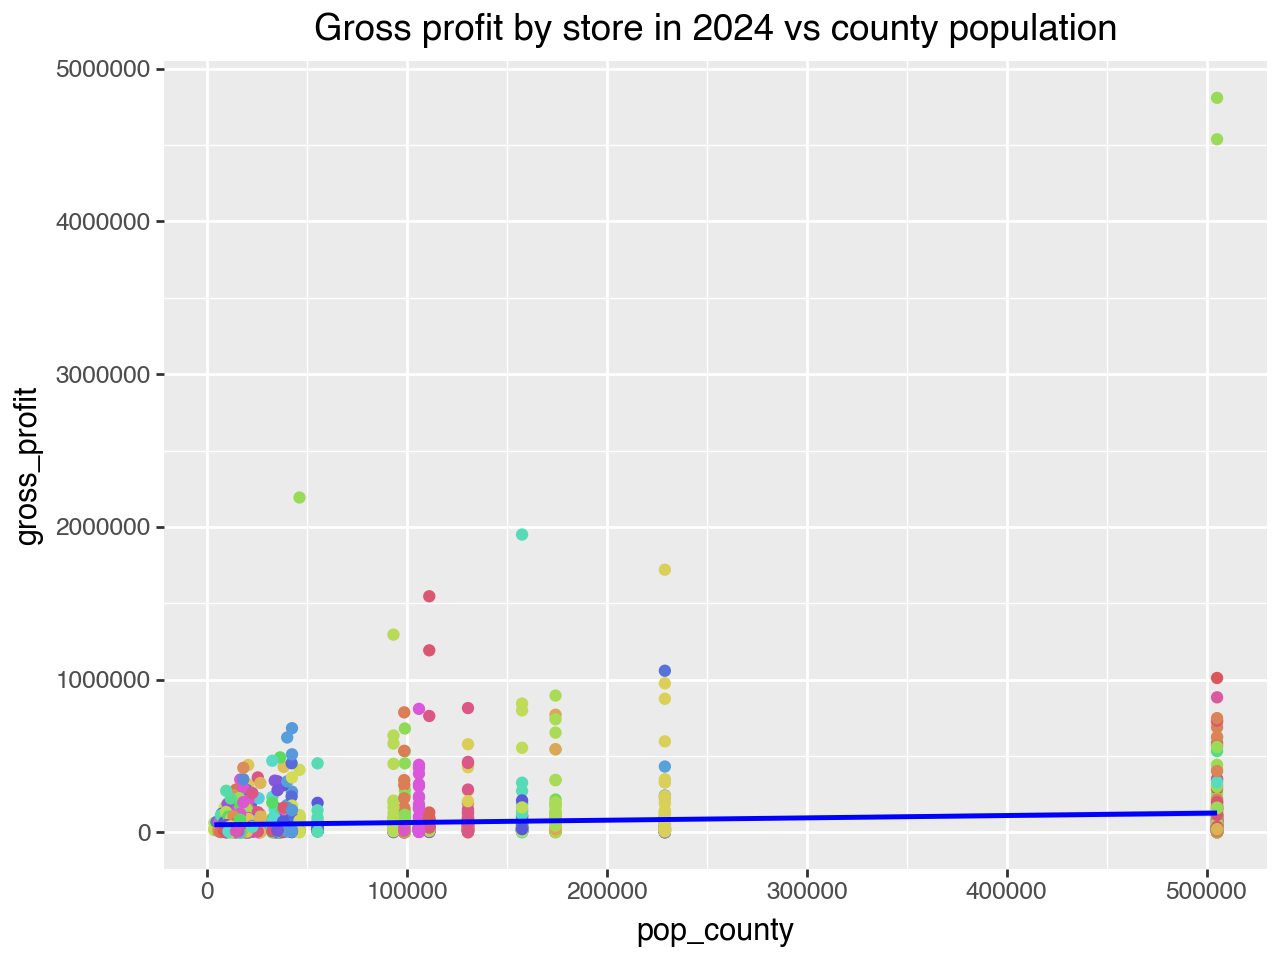

In [33]:
df_store_pop_county = df.groupby(['store', 'pop_county', 'city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop_county, p9.aes(x='pop_county', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county population') +
    p9.theme(legend_position='none')
)
plot

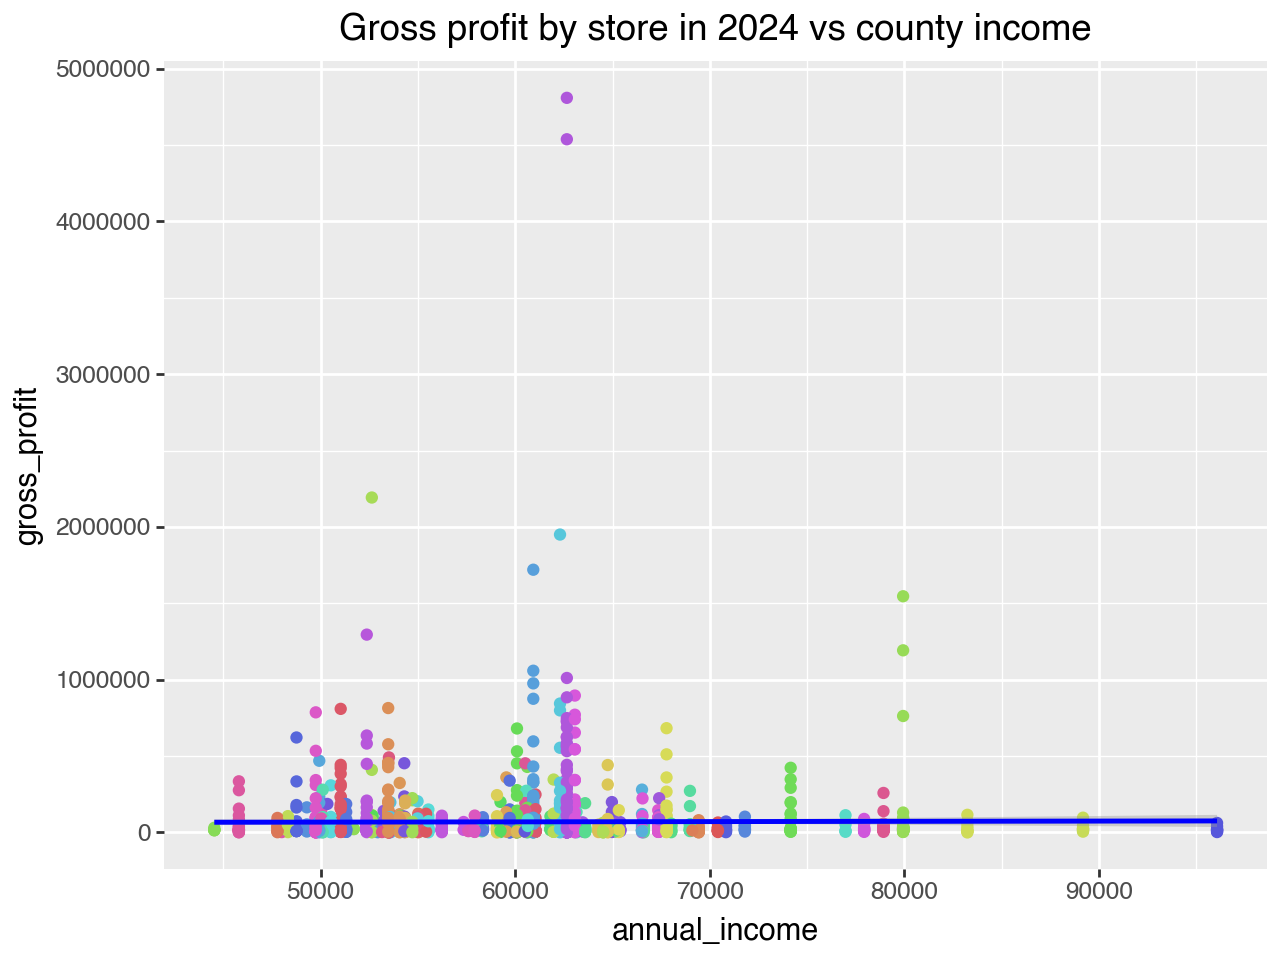

In [35]:
df_store_income = df.groupby(['store', 'annual_income', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_income, p9.aes(x='annual_income', y='gross_profit', color='county')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county income') +
    p9.theme(legend_position='none')
)
plot

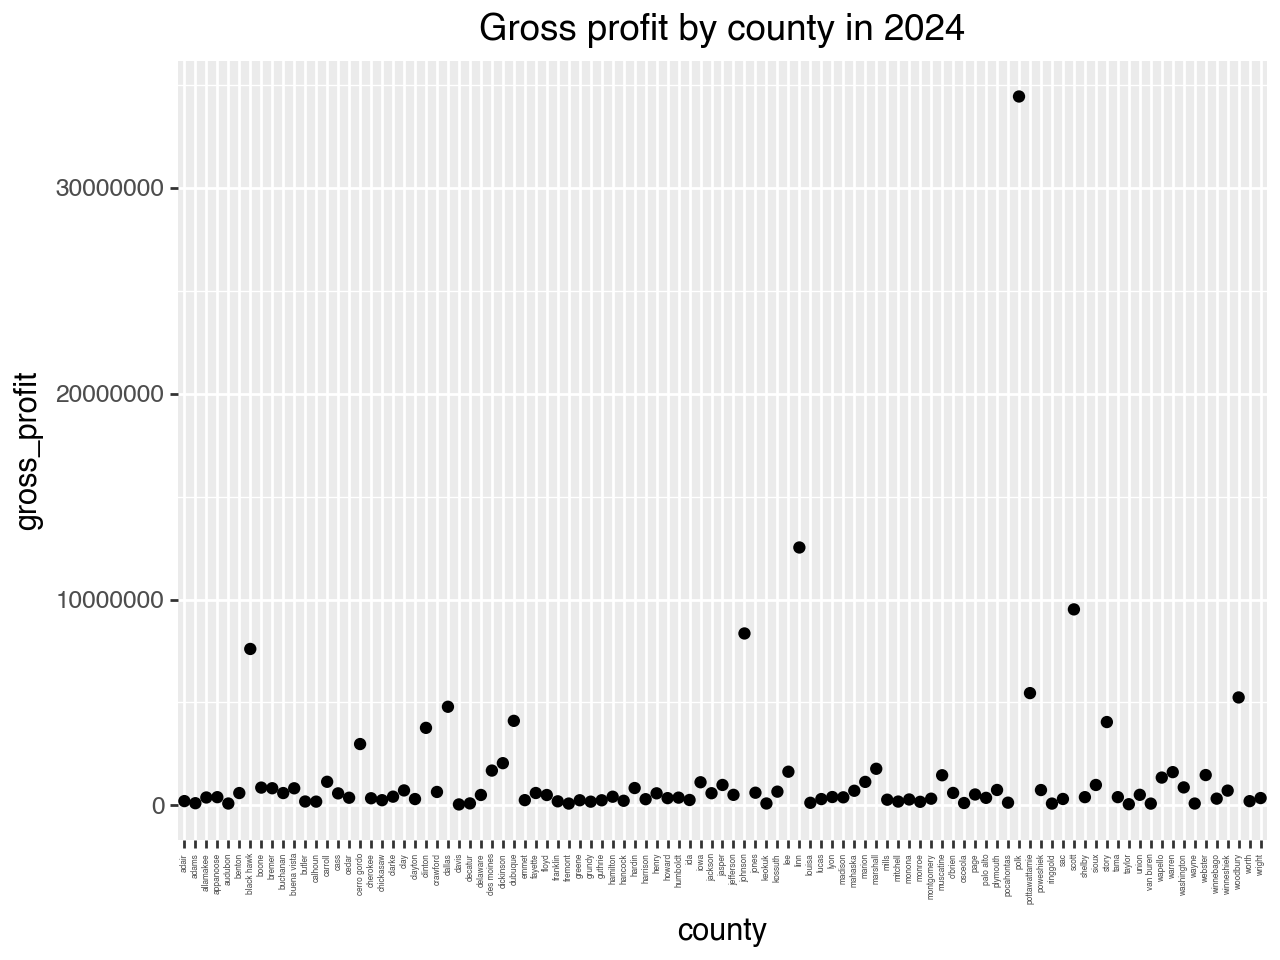

In [36]:
df_county_profit = df.groupby(['county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_county_profit, p9.aes(x='county', y='gross_profit')) +
    p9.geom_point() +
    p9.labs(title='Gross profit by county in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot

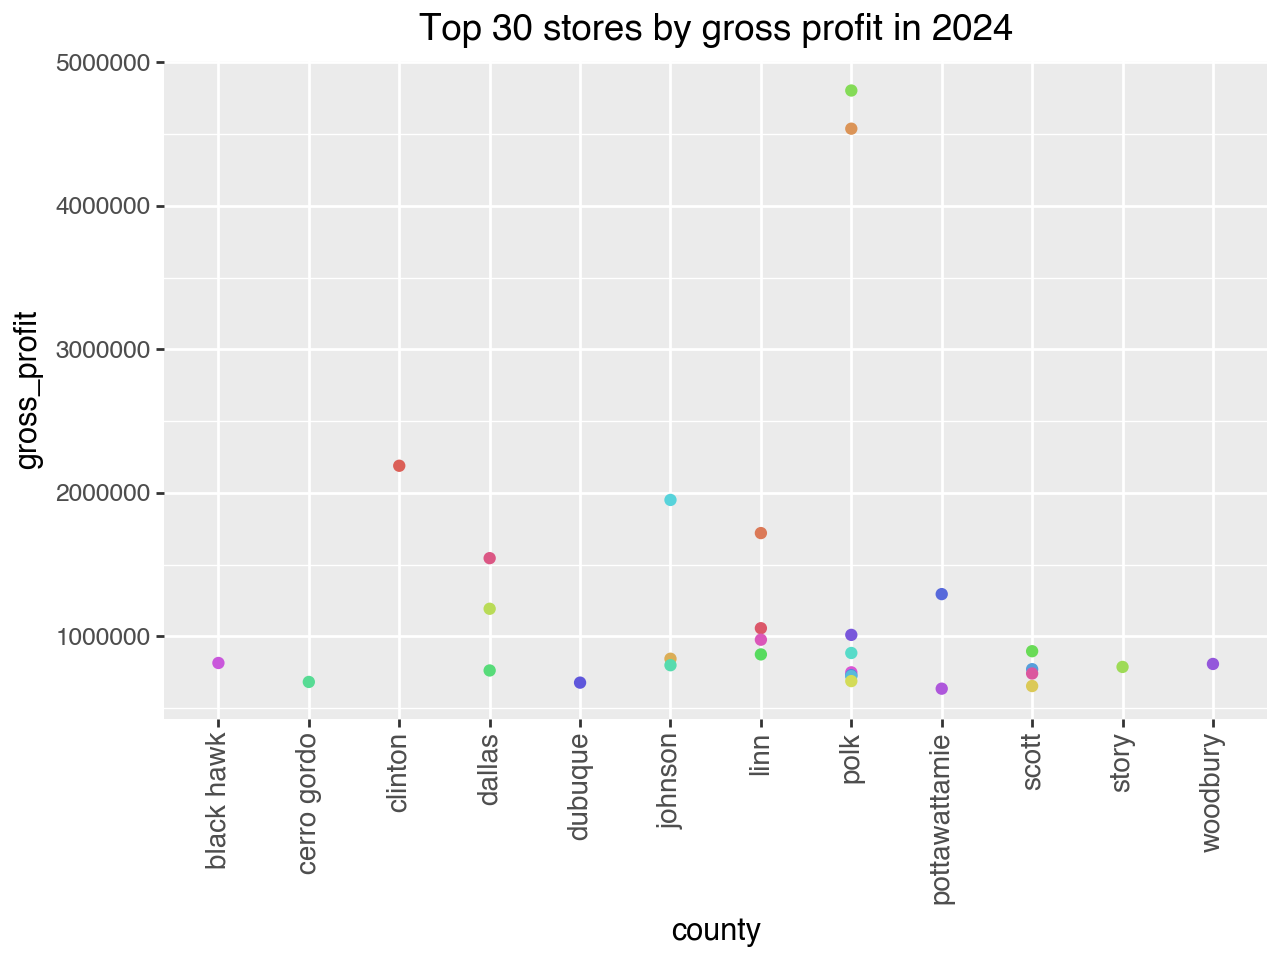

In [150]:
df_top_store = df.groupby(['store', 'city', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='county', y='gross_profit', color='store')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot

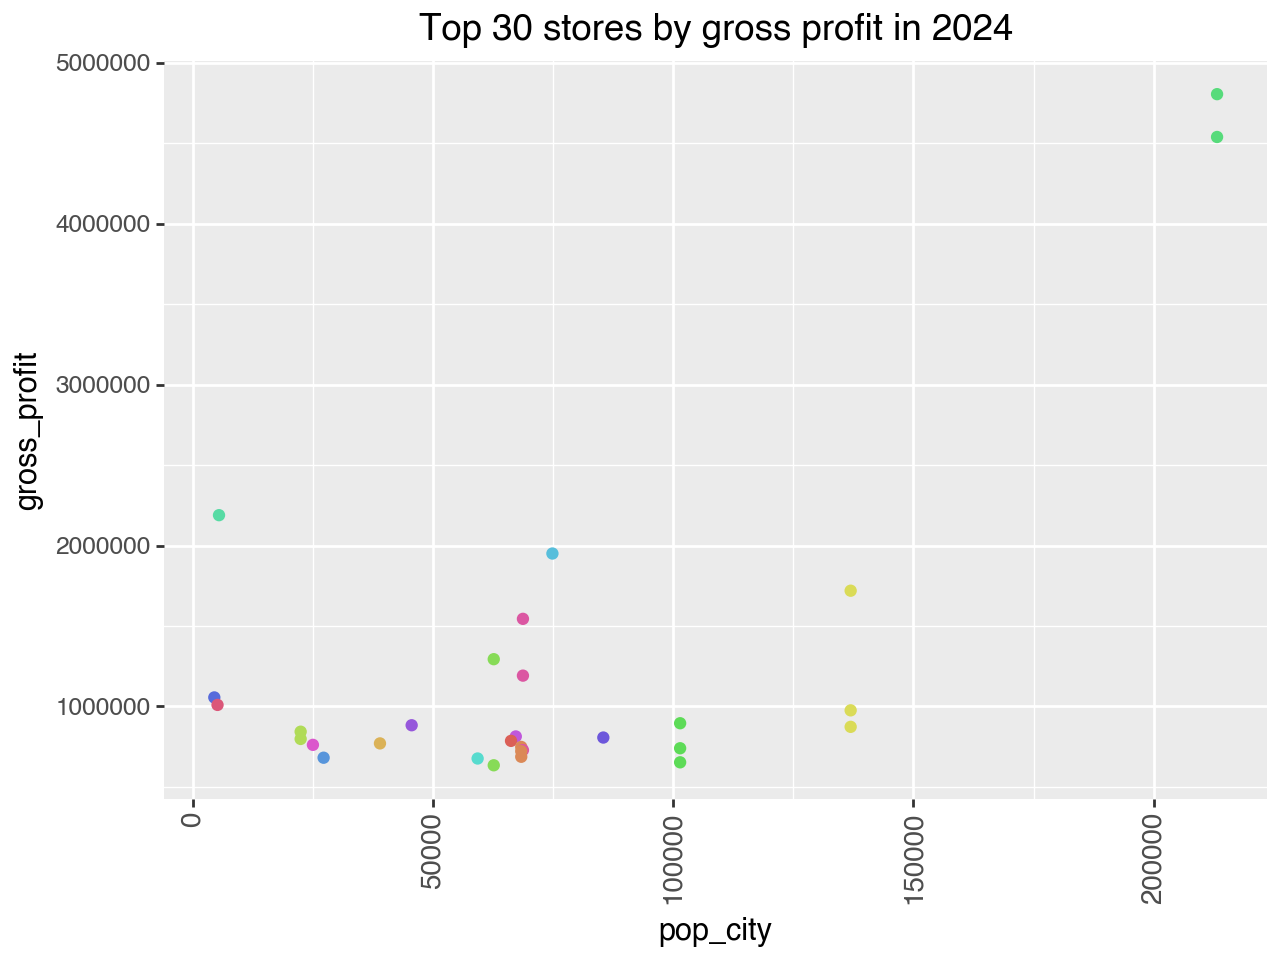

In [155]:
df_top_store = df.groupby(['store', 'city', 'county', 'pop_city'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='pop_city', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot

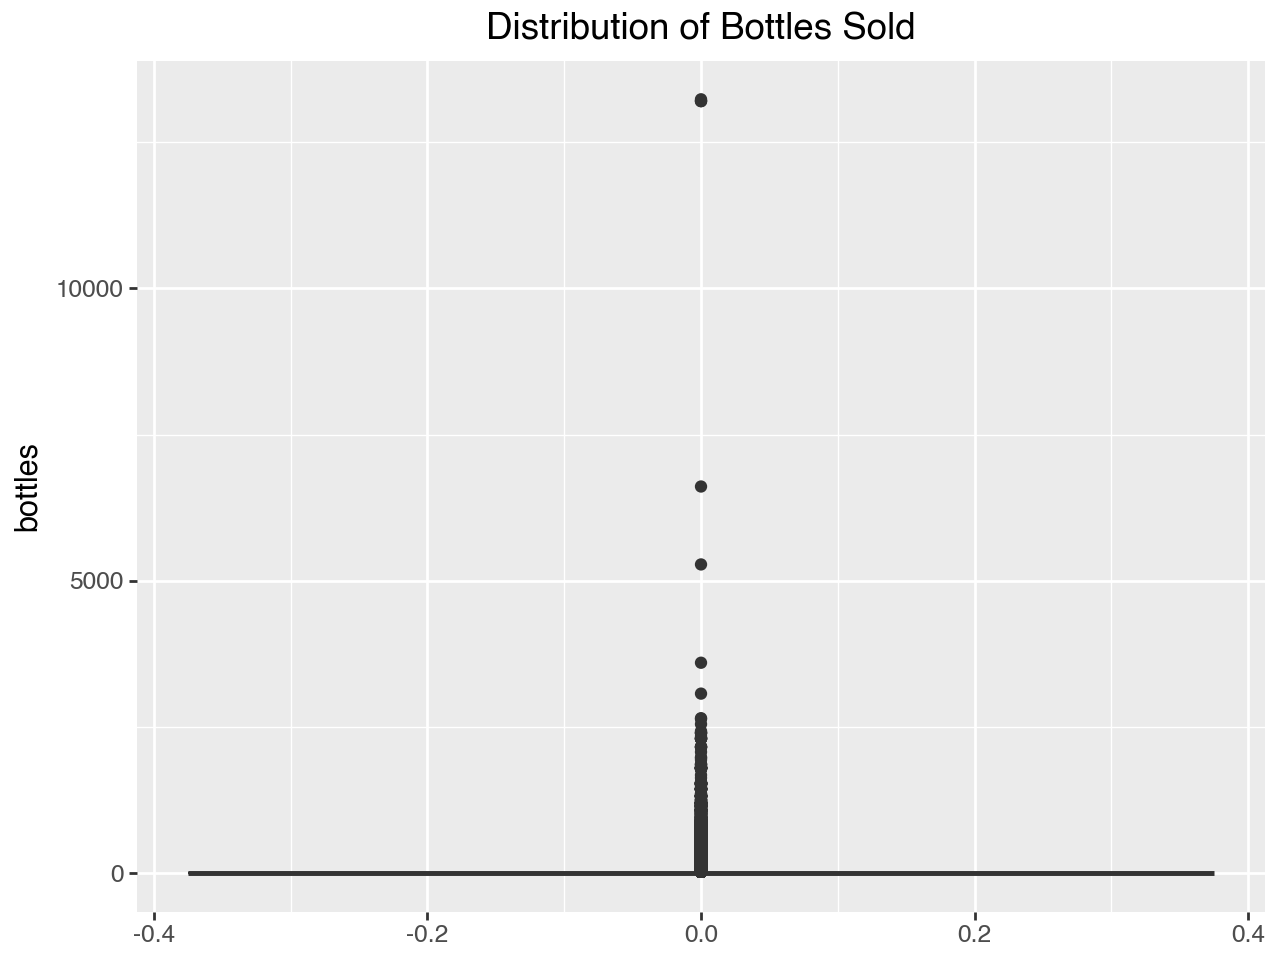

In [13]:
df_store = (
    df_google
    .groupby(['store', 'city', 'county', 'date', 'item'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store

plot = (
    p9.ggplot(df_store, p9.aes(y='bottles')) + 
    p9.geom_boxplot() +
    p9.labs(title='Distribution of Bottles Sold')
)
plot

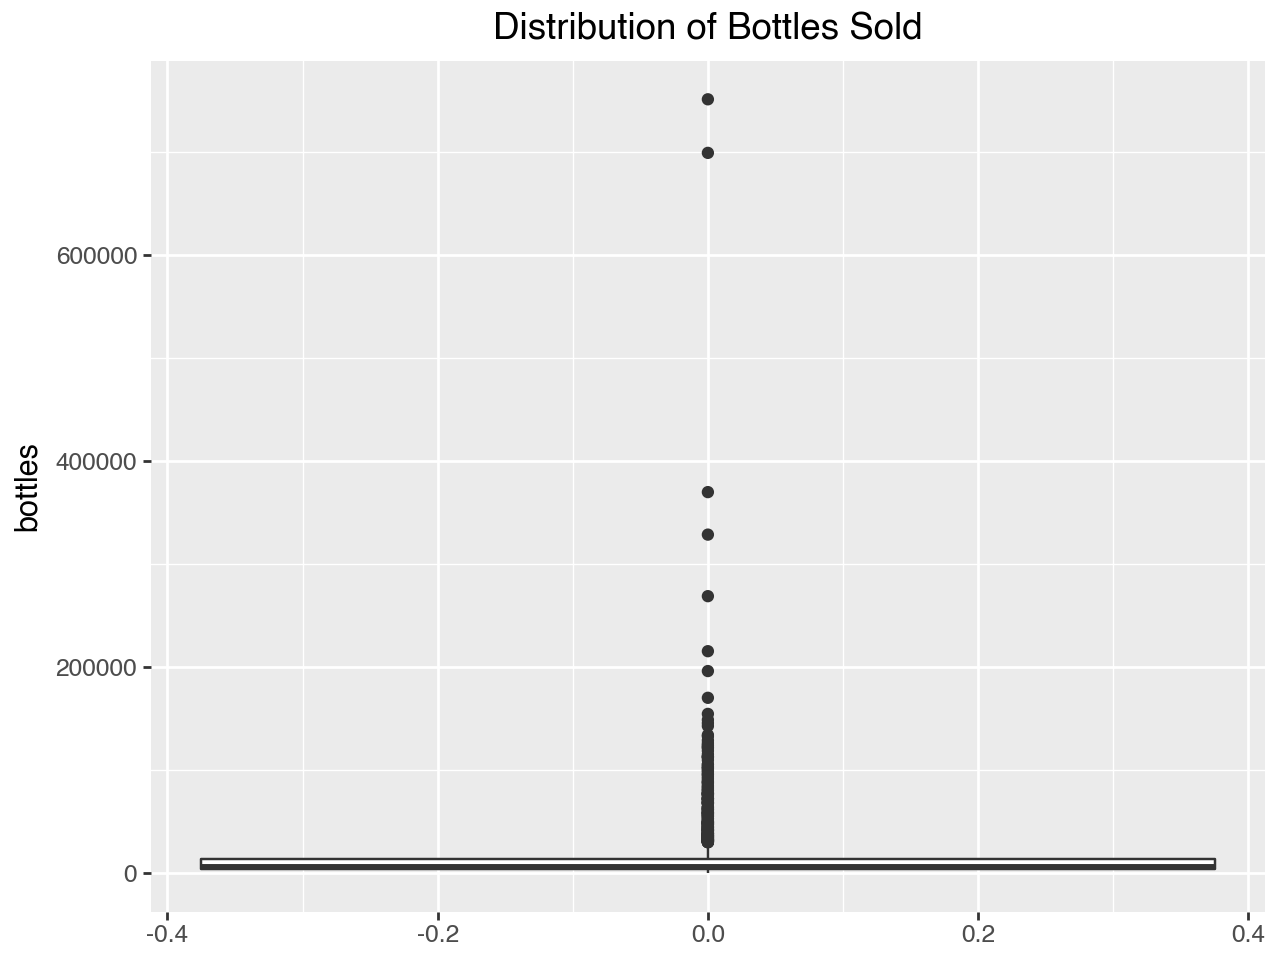

In [38]:
df_store_year = (
    df
    .groupby(['store', 'city', 'county'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store_year

plot = (
    p9.ggplot(df_store_year, p9.aes(y='bottles')) + 
    p9.geom_boxplot() +
    p9.labs(title='Distribution of Bottles Sold')
)
plot